# Annotating the heart atlas
Annotate a subsampled version of the heart cell atlas {cite:p}`litvivnukova2020cells`. Head to [https://www.heartcellatlas.org/](https://www.heartcellatlas.org/) for more information on this dataset. 

Running this notebook will automatically download the data from figshare. 

## Preliminaries

### Import packages & data

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from cell_annotator import CellAnnotator
from cell_annotator.utils import _shuffle_cluster_key_categories_within_sample

/Users/mlange/miniforge3/envs/cell_annotator/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load a subsampled version of the heart cell atlas {cite:p}`litvivnukova2020cells`. This dataset has been obtained using [scvi.data.heart_cell_atlas_subsampled()](https://docs.scvi-tools.org/en/stable/api/reference/scvi.data.heart_cell_atlas_subsampled.html#). We computed an embedding with scVI to visualize the data {cite:p}`lopez2018deep`. 

In [2]:
adata = sc.read("data/heart_atlas.h5ad", backup_url="https://figshare.com/ndownloader/files/51994787")

adata

AnnData object with n_obs × n_vars = 18641 × 1200
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_source_colors', 'cell_type_colors', 'donor_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

### Preprocess the data

Create numerical cell type labels to be used for annotation and a shuffled version thereof. 

In [3]:
adata.obs["leiden"] = adata.obs["cell_type"].copy()
adata.obs["leiden"] = adata.obs["leiden"].cat.rename_categories(
    {cat: str(i) for i, cat in enumerate(adata.obs["cell_type"].cat.categories)}
)

adata = _shuffle_cluster_key_categories_within_sample(adata, sample_key="cell_source", key_added="leiden_shuffled")

Visualize

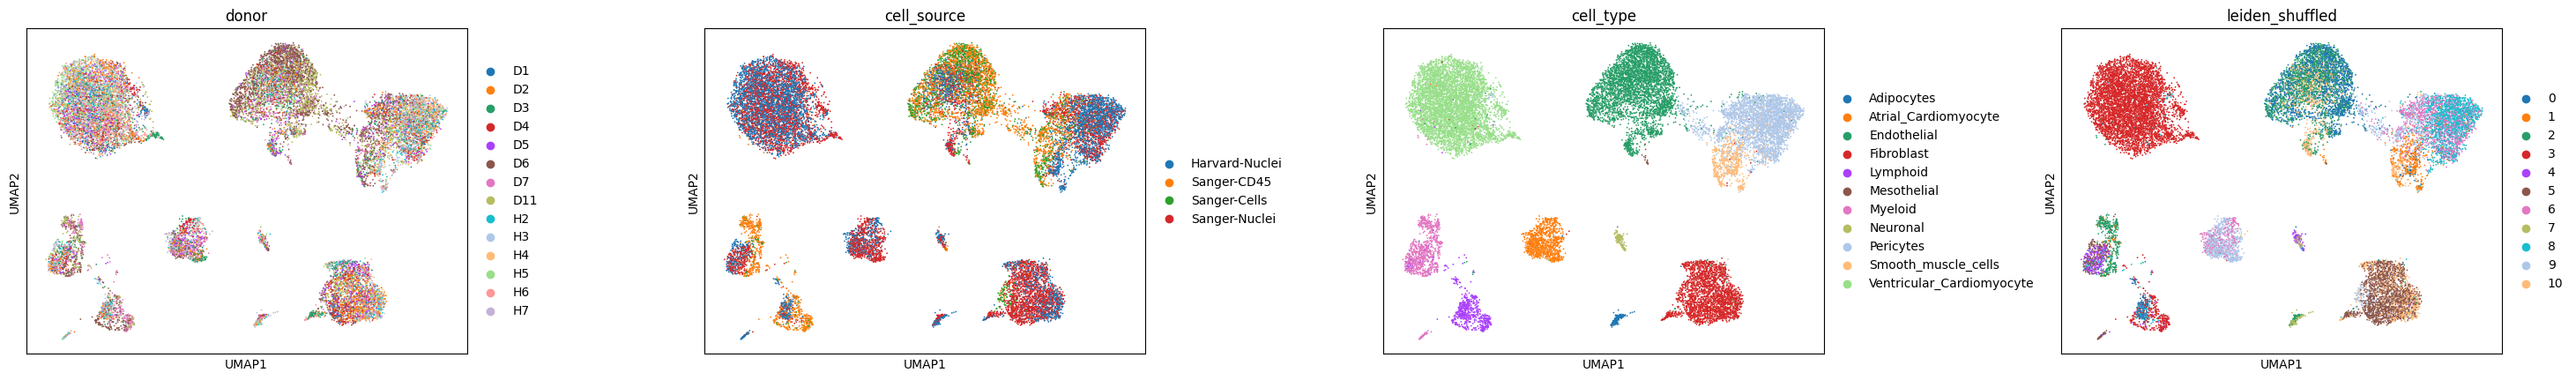

In [4]:
sc.pl.embedding(
    adata, basis="umap", color=["donor", "cell_source", "cell_type", "leiden_shuffled"], wspace=0.4, ncols=5
)

We're using the `cell_source` annotation to denote different samples, and we randomly shuffled the order of cluster labels within each sample to resemble a realistic scenario, in which we're given a dataset with several samples, with independent clustering per sample (i.e., pre-integration). 

## Query cell type labels per sample

In this notebook, we will demonstrate the simplest usage of this package, which is just a single method call. If you want to have more control over what's happening behind the scences, to check model outputs at intermediate steps or to infuse prior knowledge, head over to our more advanced tutorial: {doc}`200_human_bmmcs`. 

In [5]:
cell_ann = CellAnnotator(
    adata, species="human", tissue="heart", cluster_key="leiden_shuffled", sample_key="cell_source", model="gpt-4.1"
)
cell_ann

INFO     The environment variable `OPENAI_API_KEY` is set (that's good).                                           
INFO     Initializing `4` SampleAnnotator objects(s).                                                              


CellAnnotator(model='gpt-4.1', species='human', tissue='heart', stage='adult', cluster_key='leiden_shuffled', sample_key='cell_source')
with `4` sample(s) in `.sample_annotators`: 'Sanger-CD45', 'Sanger-Nuclei', 'Sanger-Cells', 'Harvard-Nuclei'

:::{note} A word on model choice:

The default model is currently `gpu-4o-mini`. That's enough for simpler use cases or to experiment with the package. Running this notebook with the default model will cost you less than 0.01 USD. Here, we're using a more powerful model, to demonstrate the full strength of the package. Running with this more powerful model will cost you around 0.20 USD. 
:::

In [6]:
cell_ann.annotate_clusters()

INFO     Querying cell types.                                                                                      
INFO     Writing expected cell types to `self.expected_cell_types`                                                 
INFO     Querying cell type markers.                                                                               
INFO     Writing expected marker genes to `self.expected_marker_genes`.                                            
INFO     Iterating over samples to annotate clusters.                                                              


100%|██████████| 4/4 [03:03<00:00, 45.92s/it]

INFO     Querying cell-type label de-duplication.                                                                  


INFO     Removed 4/17 cell types.                                                                                  
INFO     Iterating over samples to harmonize cell type annotations.                                                


100%|██████████| 4/4 [00:34<00:00,  8.54s/it]

INFO     Writing updated cluster labels to `adata.obs[`cell_type_predicted'].                                      


CellAnnotator(model='gpt-4.1', species='human', tissue='heart', stage='adult', cluster_key='leiden_shuffled', sample_key='cell_source')
with `4` sample(s) in `.sample_annotators`: 'Sanger-CD45', 'Sanger-Nuclei', 'Sanger-Cells', 'Harvard-Nuclei'

Under the hood, this creates one {class}`cell_annotator.SampleAnnotator` object per sample. Let's take a look at one of them: 

In [7]:
cell_ann.sample_annotators["Sanger-Cells"]

SampleAnnotator(sample_name='Sanger-Cells', n_clusters=8, n_cells=1,753)

Within each {class}`cell_annotator.SampleAnnotator`, we can inspect annotation results: 

In [8]:
cell_ann.sample_annotators["Sanger-Cells"].annotation_df

,n_cells,marker_genes,reason_for_failure,marker_gene_description,cell_type,cell_state,annotation_confidence,reason_for_confidence_estimate,cell_type_harmonized
1,51,"AIF1, S100A4, LYZ, TYROBP, FCER1G, S100A9, LAPTM5",None,"Markers AIF1, S100A4, LYZ, TYROBP, FCER1G, S10...",Macrophages,Normal,High,Multiple markers strongly match known myeloid/...,Macrophages
2,1191,"VWF, EGFL7, SLC9A3R2, CLDN5, F8, PECAM1, EMCN",None,Cluster 2 has strong expression of VWF (von Wi...,Endothelial cells,Normal,High,Multiple specific and canonical markers for en...,Endothelial cells
4,35,"CCL5, PTPRC, CORO1A, HCST, NKG7, CD69, CCL4",None,"Markers CCL5, CCL4, and NKG7 are chemokines an...","T cells (activated, likely cytotoxic T or NK c...",Activated,High,"The combination of CCL5, CCL4, NKG7, and CD69 ...",Cytotoxic T cell or NK cell
5,3,"KRT18, ITLN1, KRT19, HP, SLPI, PRG4, RARRES2",None,The cluster markers KRT18 and KRT19 are kerati...,Epicardial cells,Normal,High,"Multiple markers (KRT18, KRT19) are establishe...",Epicardial cells
6,262,"NDUFA4L2, RGS5, AGT, CPE, ACTA2, COX4I2, TPM2",None,NDUFA4L2 and RGS5 are associated with pericyte...,Pericytes,Normal,High,The presence of RGS5 and NDUFA4L2 strongly sup...,Pericytes
8,6,"PLP1, CHL1, LGI4, CRYAB, TMEM176B, NRXN1, GPM6B",None,PLP1 is a classic marker for oligodendrocytes ...,Schwann cells,Normal,High,"Multiple strong markers (PLP1, LGI4, CHL1, GPM...",Schwann cells
9,91,"DCN, C1S, SERPINF1, C7, FBLN1, CFD, LUM",None,Markers DCN and LUM are classic fibroblast mar...,Fibroblasts,Normal,High,"Multiple markers (DCN, LUM, FBLN1) are canonic...",Fibroblasts
10,114,"TAGLN, TPM2, MYH11, ACTA2, SOD3, CRYAB, IGFBP5",None,"Cluster 10 expresses TAGLN, TPM2, MYH11, and A...",Smooth Muscle Cells,Normal,High,Cluster expresses multiple well-established ca...,Smooth Muscle Cells


Further, annotations have been automatically harmonized across samples (`cell_type_harmonized`) and written to the underling {class}`anndata.AnnData` object, by default to `cell_type_predicted`. 

### Evaluate results

First, let's get clusters into a consistent ordering across annotations. This will make it easier to interpret the results in a confusion matrix. 

In [9]:
cell_ann.reorder_and_color_clusters(keys=["cell_type", "cell_type_predicted"], assign_colors=True)

INFO     Querying label ordering.                                                                                  
INFO     Querying cluster colors.                                                                                  
INFO     Writing categories for key 'cell_type'                                                                    
INFO     Writing categories for key 'cell_type_predicted'                                                          


Compute ground-truth with predicted cell type labels in a confusion matrix (across all samples). 

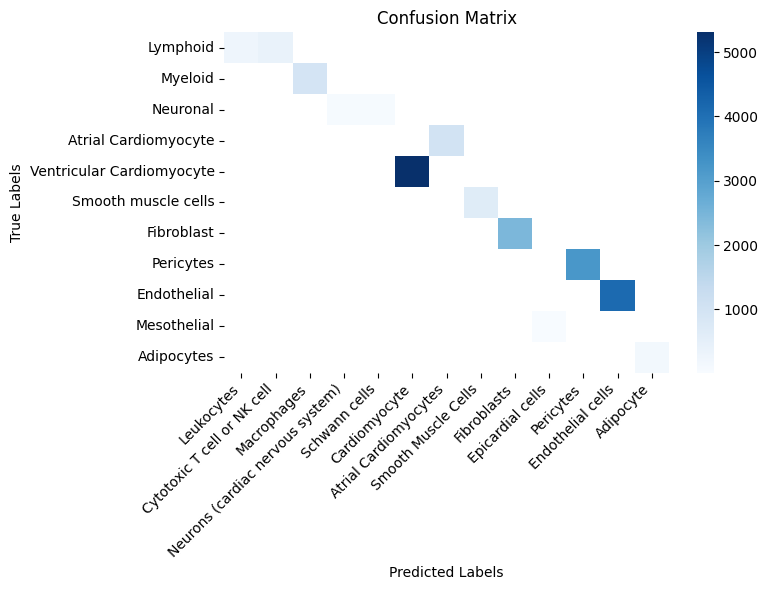

In [10]:
df = adata.obs.groupby(["cell_type", "cell_type_predicted"], observed=True).size().unstack()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=False, cmap="Blues", xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Note that your results might look slightly different, but we have found the the model behaves mostly robust and many variations are synonyms or closely related cell types. We can also compare ground-truth and predicted cell types in the UMAP embedding. 

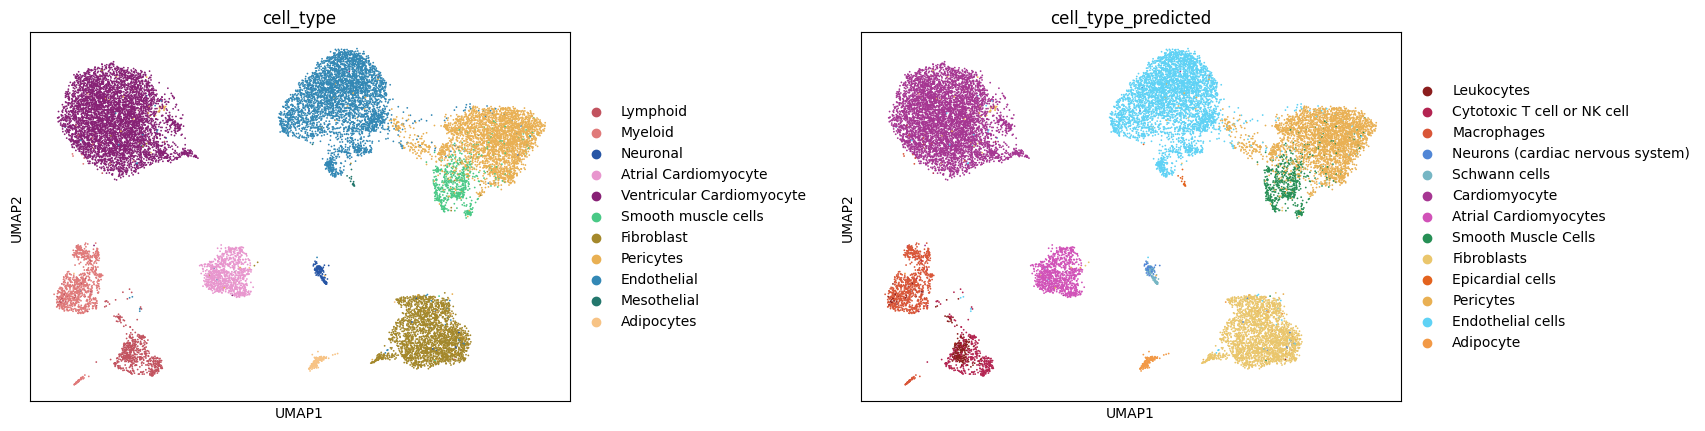

In [11]:
sc.pl.embedding(adata, basis="umap", color=["cell_type", "cell_type_predicted"], wspace=0.4, ncols=5)

Colors have been assigned automatically and should ideally be comparable across the two annotations. 